In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
import random
import numpy as np
from sklearn.datasets import make_moons, make_circles, make_classification, make_swiss_roll, make_blobs
from scipy.linalg import eigh
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.base import BaseEstimator, ClassifierMixin
from math import inf
import sklearn.metrics.pairwise
from sklearn import metrics
from sklearn import preprocessing
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

# Utilitary functions

In [5]:
def print_averaged_results(averaged_result, models):
    print("n_classes: %d, \t n_samples %d, \t n_features %d, \t n_runs %d" % (n_classes, n_samples, n_features, len(SEEDS)))
    print(82 * '_')
    print('init\t\tARI\tv-meas\thomo\tcompl\tAMI')    

    for i in range(len(models)):
        print('%-9s\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f' % (models[i][0],
                                                      averaged_result[i][0], averaged_result[i][1],
                                                      averaged_result[i][2],averaged_result[i][3],
                                                      averaged_result[i][4]))
    print(82 * '_')

    
def print_model(model, title, subplot, rows, columns, i, save=False):
    # Step size of the mesh. Decrease to increase the quality of the VQ.
    h = .1   
    
    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point in mesh. Use last trained model.
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    
    if subplot == True:
        fig.add_subplot(rows, columns, i)
    else:
        plt.figure(1)
        plt.clf()
    

    plt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.Paired,
               aspect='auto', origin='lower', alpha=0.5)

    plt.scatter(X[:, 0], X[:, 1], s=40, alpha=0.7, c=labels)
    plt.title(title)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    if save == True:
        plt.savefig(title + '.png', dpi=300)

def bench_k_means(estimator, name, data, verbose=False):
    estimator.fit(data)
    
    ari = metrics.adjusted_rand_score(labels, estimator.labels_)
    v_score = metrics.v_measure_score(labels, estimator.labels_)
    homog = metrics.homogeneity_score(labels, estimator.labels_)
    completeness = metrics.completeness_score(labels, estimator.labels_)
    ami = metrics.adjusted_mutual_info_score(labels,  estimator.labels_, average_method='arithmetic')
    
    if verbose: print('%-9s\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f' % (name, ari, v_score, homog, completeness, ami))
    
    return [ari, v_score, homog, completeness, ami]


def plot3d(label):
    fig = plt.figure()
    ax = p3.Axes3D(fig)
    ax.view_init(7, -80)
    for l in np.unique(label):
        ax.scatter(X[label == l, 0], X[label == l, 1], X[label == l, 2],
                   color=plt.cm.jet(float(l) / np.max(label + 1)),
                   s=20, edgecolor='k')

    plt.show()
    
def print_img(clusters):
    plt.scatter(X[:, 0], X[:, 1], c=clusters)
    plt.show()
    
    
# Define different kernels
class linear_kernel:
    def run(self, X, Y):
        return sklearn.metrics.pairwise.linear_kernel(X, Y)

class poly_kernel:
    def __init__(self, c0=1, d=3, gamma=None):
        self.c0 = c0
        self.d = d
        self.gamma = gamma
        
    def run(self, X, Y):
        return sklearn.metrics.pairwise.polynomial_kernel(X, Y, self.d, self.gamma, self.c0)
    
class sigmoid_kernel:
    def __init__(self, c0=1, gamma=2):
        self.c0 = c0
        self.gamma = gamma
        
    def run(self, X, Y):
        return sklearn.metrics.pairwise.sigmoid_kernel(X, Y, self.gamma, self.c0)


class rbf_kernel:
    def __init__(self, gamma=2):
        self.gamma = gamma
        
    def run(self, X, Y):
        return sklearn.metrics.pairwise.rbf_kernel(X, Y, self.gamma)

# K-Means

In [6]:
class K_Means():
    
    def __init__(self, n_clusters=2):
        self.n_clusters = n_clusters
        
    def _randomize_centroids(self, X):
        mins = np.amin(X, axis=0)
        maxs = np.amax(X, axis=0)
        
        return list(np.random.uniform(mins, maxs, (self.n_clusters,len(mins))))
    
    def _get_closest_centroid(self, point, centroids):
        differences = np.sum(np.abs(point - centroids)**2, axis=-1)**(1./2)
        return np.argmin(differences)
    
        
    def _assign_points_to_clusters(self, X, centroids):
        labels = []
        
        for i in range(X.shape[0]):
            cl = self._get_closest_centroid(X[i], centroids)
            labels.append(cl)
            
        return np.array(labels)
        
    def _update_centroids(self, X, assignments):
        centroids = []
        
        for i in range(self.n_clusters):
            centroids.append(np.mean(X[assignments == i], axis=0))
        
        return centroids
    
    
    def fit(self, X):
        centroids = self._randomize_centroids(X)
        assignments = self._assign_points_to_clusters(X, centroids)
        old_assignments = None
        
        while (assignments != old_assignments).any():
            centroids = self._update_centroids(X, assignments)
            old_assignments = assignments
            assignments = self._assign_points_to_clusters(X, centroids)
            
        self.labels_ = assignments
        self.centroids_ = centroids
        return self
        

# Kernel K-Means

In [7]:
class KernelKMeans(BaseEstimator, ClassifierMixin):
    
    def __init__(self, n_clusters=2, max_iter=3000, kernel="linear", gamma=None, degree=3, coef0=1):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.kernel = kernel
        self.gamma = gamma
        self.degree = degree
        self.coef0 = coef0
        
    def _get_kernel(self, X, Y):
        if self.kernel == "poly":
            return poly_kernel(self.coef0, self.degree, self.gamma).run(X, Y)
        elif self.kernel == "rbf":
            return rbf_kernel(self.gamma).run(X, Y)
        elif self.kernel == "sigmoid":
            return sigmoid_kernel(self.coef0, self.gamma).run(X,Y)
        else:
            return linear_kernel().run(X, Y)
        
    
    def _compute_dist_to_clusters(self, K, dist, within_distances, training=True):
        
        for j in range(self.n_clusters):
            Cj = np.sum(self.labels_ == j)
            
            dist[:, j] -= 2 * np.sum(K[:, self.labels_ == j], axis = 1) / Cj
            
            if training == True:
                d_j = np.sum(K[self.labels_ == j][:, self.labels_ == j]) / (Cj * Cj)
                within_distances[j] = d_j
                dist[:, j] += d_j
            else:
                dist[:, j] += within_distances[j]
                        
    def fit(self, X):
        iteration = 0
        n_samples = X.shape[0]
        
        self.X_fit_ = X
        
        K = self._get_kernel(X, X)
        
        self.labels_ = np.random.randint(self.n_clusters, size=n_samples)
        
        dist = np.zeros((n_samples, self.n_clusters))
        self.within_distance_ = np.zeros(self.n_clusters)  
        
        while (True):
            iteration += 1
            
            self._compute_dist_to_clusters(K, dist, self.within_distance_, True)
            old_labels = self.labels_
            self.labels_ = dist.argmin(axis=1)
            
            if (self.labels_ == old_labels).all():
                break
            
            
            if iteration == self.max_iter:
                break
                
        return self

    def predict(self, X):
        K = self._get_kernel(X, self.X_fit_)
        n_samples = X.shape[0]
        dist = np.zeros((n_samples, self.n_clusters))
        self._compute_dist_to_clusters(K, dist, self.within_distance_, False)
        return dist.argmin(axis=1)
    


# Testing Area

## Data Loading / Generation

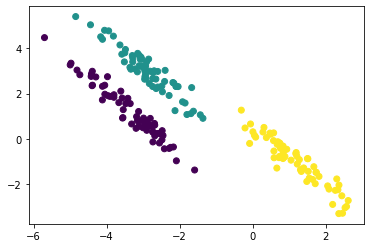

In [8]:
n_samples = 200
X, labels = make_blobs(n_samples=n_samples, random_state=170)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X = np.dot(X, transformation)

n_samples, n_features = X.shape
n_classes = len(np.unique(labels))

print_img(labels)

In [ ]:
# X = pd.read_csv("./zhans.csv")
# y = X['Label']
# X = X.drop(['Label'], axis=1)
# X = np.array(X)

# le = preprocessing.LabelEncoder().fit(y)
# labels = le.transform(y) 
# n_samples, n_features = X.shape
# n_classes = len(np.unique(labels))

# print_img(labels)

In [ ]:
SEEDS = random.sample(range(1, 100), 1)
SEEDS = [33]

result = []

for sed in SEEDS:
    np.random.seed(sed)

    ## K-Means ##
#     models = [
#         ("K-Means", KMeans(n_clusters=n_classes))
#     ]

    # ## SIGMOID ##
#     models = [
#         ("KKM-γ:1-c:-1", KernelKMeans(n_clusters=n_classes, kernel = "sigmoid", gamma=0.1, coef0=14)),
#         ("KKM-γ:5-c:-1", KernelKMeans(n_clusters=n_classes, kernel = "sigmoid", gamma=0.5, coef0=14)),
#         ("KKM-γ:10-c:-1", KernelKMeans(n_clusters=n_classes, kernel = "sigmoid", gamma=0.9, coef0=14)),
#         ("KKM-γ:15-c:-1", KernelKMeans(n_clusters=n_classes, kernel = "sigmoid", gamma=1.5, coef0=14)),

#         ("KKM-γ:10-c:-10", KernelKMeans(n_clusters=n_classes, kernel = "sigmoid", gamma=0.01, coef0=4.5)),
#         ("KKM-γ:12-c:-10", KernelKMeans(n_clusters=n_classes, kernel = "sigmoid", gamma=0.1, coef0=4.5)),
#         ("KKM-γ:14-c:-10", KernelKMeans(n_clusters=n_classes, kernel = "sigmoid", gamma=0.2, coef0=4.5)),
#         ("KKM-γ:15-c:-10", KernelKMeans(n_clusters=n_classes, kernel = "sigmoid", gamma=0.3, coef0=4.5)),  

#         ("KKM-γ:20-c:-15", KernelKMeans(n_clusters=n_classes, kernel = "sigmoid", gamma=2, coef0=-0.5)),
#         ("KKM-γ:30-c:-15", KernelKMeans(n_clusters=n_classes, kernel = "sigmoid", gamma=2.5, coef0=-0.5)),
#         ("KKM-γ:40-c:-15", KernelKMeans(n_clusters=n_classes, kernel = "sigmoid", gamma=3, coef0=-0.5)),
#         ("KKM-γ:50-c:-15", KernelKMeans(n_clusters=n_classes, kernel = "sigmoid", gamma=3.5, coef0=-0.5)),  
        
#     ]

    # ## POLY ##
#     models = [
#         ("d:2-γ:.5-c:-1", KernelKMeans(n_clusters=n_classes, kernel = "poly", gamma=0.1, coef0=-4.286, degree=2)),
#         ("d:2-γ:.5-c:-1", KernelKMeans(n_clusters=n_classes, kernel = "poly", gamma=0.2, coef0=-5.286, degree=2)),
#         ("d:2-γ:.5-c:-1", KernelKMeans(n_clusters=n_classes, kernel = "poly", gamma=0.3, coef0=-6.286, degree=2)),
#         ("d:2-γ:.5-c:-1",KernelKMeans(n_clusters=n_classes, kernel = "poly", gamma=0.4, coef0=-7.286, degree=2)),

#         ("d:2-γ:10-c:1", KernelKMeans(n_clusters=n_classes, kernel = "poly", gamma=0.1, coef0=-5, degree=3)),
#         ("d:2-γ:20-c:1", KernelKMeans(n_clusters=n_classes, kernel = "poly", gamma=0.5, coef0=-5, degree=3)),
#         ("d:2-γ:30-c:1", KernelKMeans(n_clusters=n_classes, kernel = "poly", gamma=1, coef0=-5, degree=3)),
#         ("d:2-γ:40-c:1",KernelKMeans(n_clusters=n_classes, kernel = "poly", gamma=1.5, coef0=-5, degree=3)),

#         ("d:4-γ:10-c:1", KernelKMeans(n_clusters=n_classes, kernel = "poly", gamma=10, coef0=-30, degree=2)),
#         ("d:4-γ:20-c:1", KernelKMeans(n_clusters=n_classes, kernel = "poly", gamma=20, coef0=-30, degree=3)),
#         ("d:4-γ:30-c:1", KernelKMeans(n_clusters=n_classes, kernel = "poly", gamma=30, coef0=-30, degree=4)),
#         ("d:4-γ:40-c:1", KernelKMeans(n_clusters=n_classes, kernel = "poly", gamma=40, coef0=-30, degree=5)),
#     ]

    ## RBF ##   
    models = [
        ("KKM-γ:0.001", KernelKMeans(n_clusters=n_classes, kernel = "rbf", gamma = 0.5)),
        ("KKM-γ:0.01", KernelKMeans(n_clusters=n_classes, kernel = "rbf", gamma = 0.7)),
        ("KKM-γ:0.1", KernelKMeans(n_clusters=n_classes, kernel = "rbf", gamma = 1)), 
        ("KKM-γ:0.5", KernelKMeans(n_clusters=n_classes, kernel = "rbf", gamma = 1.5)),
    ]

    per_seed_result = []
    for model in models:
        per_seed_result.append(bench_k_means(model[1], name=model[0], data=X, verbose=False))
        

    result.append(per_seed_result)


    
averaged_result = np.mean(result, axis=0)
print_averaged_results(averaged_result, models)


In [ ]:
columns = 4
rows = 1
fig=plt.figure(figsize=(columns*6.4, 4.8*rows))

for i in range(0, columns*rows):
    if i == columns * rows - 1:
        print_model(models[i][1], models[i][0], True, rows, columns, i+1, False) # set to true to print
    else:
        print_model(models[i][1], models[i][0], True, rows, columns, i+1, False)

plt.show()

## Grid Search for the best hyper-parameters

In [ ]:
gammas = np.logspace(-2, 1, 500)
coeffs = np.linspace(-20, 20, num=20)
degs = [2, 3, 4]



SEEDS = random.sample(range(1, 100), 5)
kernel = "rbf"

result = []
for sed in SEEDS:
    np.random.seed(sed)
    print("Running with Seed", sed)
    
    per_seed_result = []
    model_names = []
    
    if kernel == "rbf":
        for g in gammas:
            model = KernelKMeans(n_clusters=n_classes, kernel = "rbf", gamma=g)
            per_seed_result.append(bench_k_means(model, name=str(g), data=X, verbose=False))
            model_names.append('%.3f' % g)
                
            
    elif kernel == "sigmoid":
        for g in gammas:
            for coef in coeffs:
                model = KernelKMeans(n_clusters=n_classes, kernel = "sigmoid", gamma=g, coef0=coef)
                per_seed_result.append(bench_k_means(model, name=str(g)+str(coef), data=X, verbose=False))
                model_names.append('%.3f|%.3f' % (g, coef))
                
    elif kernel == "poly":
        for d in degs:
            print("Degree", d)
            for coef in coeffs:
                for g in gammas:
                    model = KernelKMeans(n_clusters=n_classes, kernel = "poly", gamma=g, coef0=coef, degree=d)
                    per_seed_result.append(bench_k_means(model, name=str(g)+str(coef)+str(d), data=X, verbose=False))
                    model_names.append('%.3f|%.3f|%.3f' % (g, coef, d))

    result.append(per_seed_result)
    
averaged_result = np.mean(result, axis=0)

df = pd.DataFrame(averaged_result, columns=["ARI", "v-meas", "homo","compl", "AMI"])
df['Model'] = model_names
sortedDF = df.sort_values(by ='ARI', ascending=False)
print(sortedDF.head())

index = np.argmax(result, axis=0)[0][0]
print("Best Seed:", SEEDS[index])

In [ ]:
# np.random.seed(37)

model = KernelKMeans(n_clusters=n_classes, kernel = "rbf", gamma=0.937).fit(X)
print_model(model, "Best_Model", False, -1, -1, -1, False)